# How to train a new language model from scratch using Transformers and Tokenizers

Copyright 2021, Denis Rothman. Denis Rothman adapted a Hugging Face reference notebook to pretrain a transformer model. The next steps would be to work on building a larger dataset and testing several transformer models. 

It is recommended to understand this notebook. The emergence of GPT-3 engines has produced an API that can outperform many trained transformers models. However, to show a transformer what to do with the input datasets, it is essential to understand how they are trained.

The Transformer model of this Notebook is a Transformer model named ***KantaiBERT***. ***KantaiBERT*** is trained as a RoBERTa Transformer with DistilBERT architecture. The dataset was compiled with three books by Immanuel Kant downloaded from the [Gutenberg Project](https://www.gutenberg.org/). 


***KantaiBERT*** was pretrained with a small model of 84 million parameters using the same number of layers and heads as DistilBert, i.e., 6 layers, 768 hidden size,and 12 attention heads. ***KantaiBERT*** is then fine-tuned for a downstream masked Language Modeling task.

### The Hugging Face original Reference and notes:

Notebook edition (link to original of the reference blogpost [link](https://huggingface.co/blog/how-to-train)).


#Step 1: Loading the dataset

In [1]:
from IPython.display import Image     #This is used for rendering images in the notebook

In [ ]:
#@title Step 1: Loading the Dataset
#1.Load kant.txt using the Colab file manager
#2.Downloading the file from GitHubant
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter04/kant.txt --output "kant.txt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.7M  100 10.7M    0     0  44.0M      0 --:--:-- --:--:-- --:--:-- 43.8M


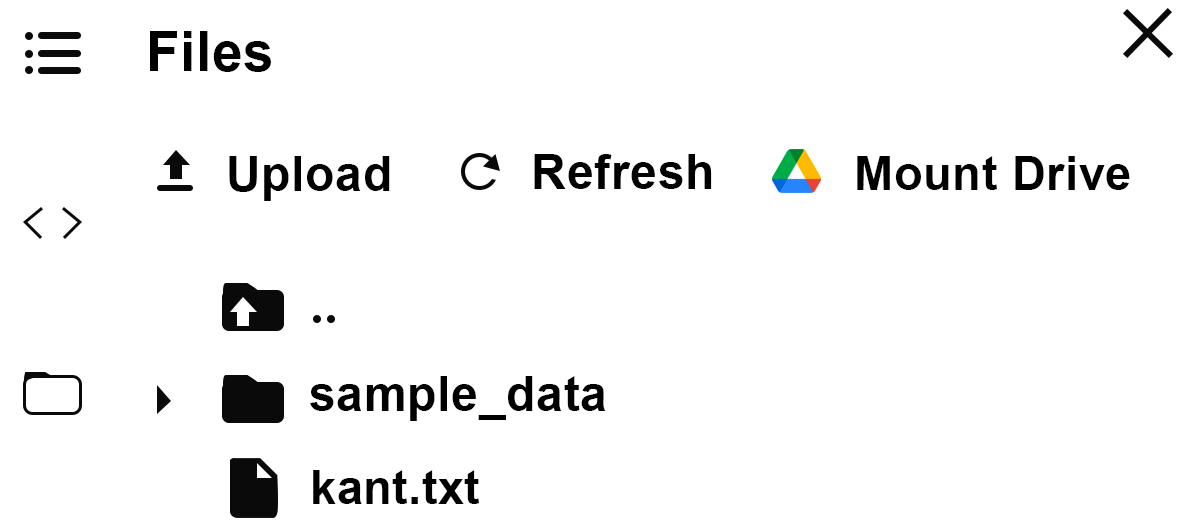

In [9]:
Image('https://github.com/Denis2054/Transformers-for-NLP-2nd-Edition/raw/main/Notebook%20images/04/B17948_04_01.png', width=400) #This is used for rendering images in the notebook

#Step 2: Installing Hugging Face transformers

In [ ]:
#@title Step 2:Installing Hugging Face Transformers
# We won't need TensorFlow here
!pip uninstall -y tensorflow
# Install `transformers` from master
!pip install git+https://github.com/huggingface/transformers
!pip list | grep -E 'transformers|tokenizers'
# transformers version at notebook update --- 2.9.1
# tokenizers version at notebook update --- 0.7.0

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-i9hvlcar
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-i9hvlcar
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 67 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 15.5 MB/s 
     |████████████████████████████████| 895 kB 82.7 MB/s 
     |████████████████████████████████| 6.5 MB 69.4 MB/s 
  Created wheel for transformers: filename=transformers-4.18.0.dev0-py3-none-any.whl size=3830965 sha256=dbaaa5f2d5e0761eb9ae8d3e152670ef84d74d595dadad9397d365c7e657a860
  Stored in directory: /tmp/pip-ephem-wheel-cache-f2r83a4w/wheels/35/2e/a7/d819e3310040329f0f47e57c9e3e7a7338aa5e74c49acfe522
Successfully built transformers
  Attem

#Step 3: Training a tokenizer

In [ ]:
#@title Step 3: Training a Tokenizer
%%time 
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer

paths = [str(x) for x in Path(".").glob("**/*.txt")]
# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files=paths, vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

CPU times: user 5.76 s, sys: 317 ms, total: 6.08 s
Wall time: 1.73 s


#Step 4: Saving the files to disk

In [ ]:
#@title Step 4: Saving the files to disk
import os
token_dir = '/content/KantaiBERT'
if not os.path.exists(token_dir):
  os.makedirs(token_dir)
tokenizer.save_model('KantaiBERT')

['KantaiBERT/vocab.json', 'KantaiBERT/merges.txt']

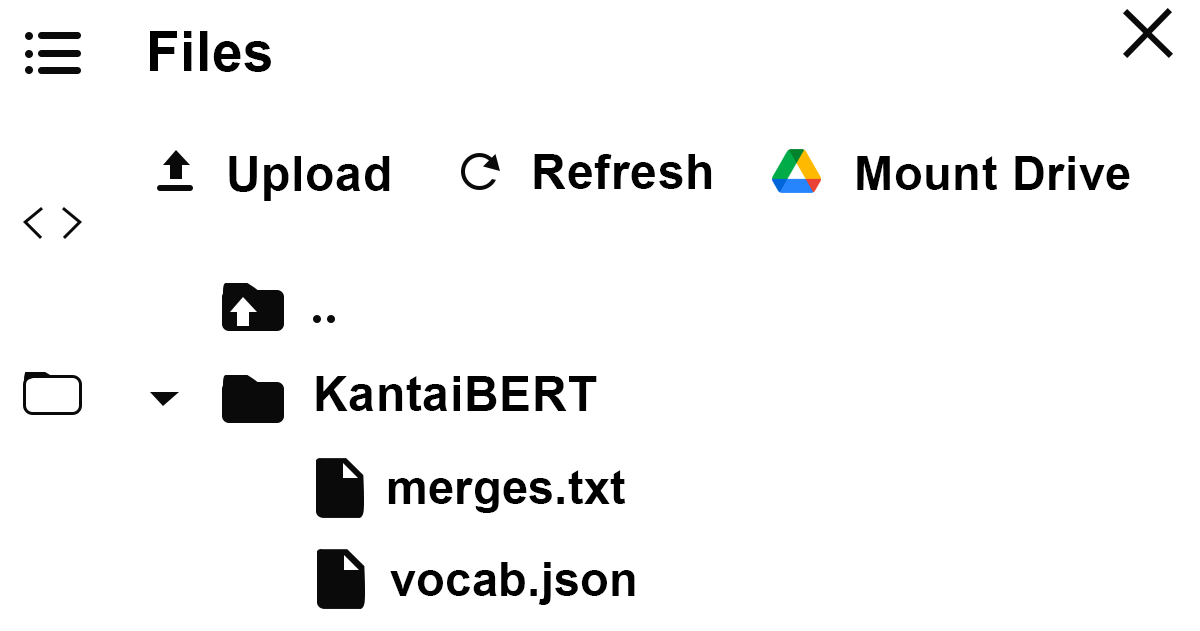

In [8]:
Image('https://github.com/Denis2054/Transformers-for-NLP-2nd-Edition/raw/main/Notebook%20images/04/B17948_04_02.png', width=400) #This is used for rendering images in the notebook

#Step 5: Loading the trained tokenizer files

In [ ]:
#@title Step 5 Loading the Trained Tokenizer Files 
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

tokenizer = ByteLevelBPETokenizer(
    "./KantaiBERT/vocab.json",
    "./KantaiBERT/merges.txt",
)

In [ ]:
tokenizer.encode("The Critique of Pure Reason.").tokens

['The', 'ĠCritique', 'Ġof', 'ĠPure', 'ĠReason', '.']

In [ ]:
tokenizer.encode("The Critique of Pure Reason.")

Encoding(num_tokens=6, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

#Step 6: Checking Resource Constraints: GPU and NVIDIA

In [ ]:
#@title Step 6: Checking Resource Constraints: GPU and NVIDIA 
!nvidia-smi

Sat Mar  5 11:42:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Checking that PyTorch Sees CUDA
import torch
torch.cuda.is_available()

True

#Step 7: Defining the configuration of the model

In [ ]:
#@title Step 7: Defining the configuration of the Model
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=52_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [ ]:
print(config)

RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



#Step 8: Reloading the tokenizer in transformers

In [ ]:
#@title Step 8: Re-creating the Tokenizer in Transformers
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("./KantaiBERT", max_length=512)

#Step 9: Initializing a model from scratch

In [ ]:
#@title Step 9: Initializing a Model From Scratch
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)
print(model)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

#Exploring the parameters

In [ ]:
print(model.num_parameters())
# => 84,095,008 parameters

83504416


In [ ]:
#@title Exploring the Parameters
LP=list(model.parameters())
lp=len(LP)
print(lp)
for p in range(0,lp):
  print(LP[p])

106
Parameter containing:
tensor([[ 0.0143,  0.0042, -0.0039,  ...,  0.0202, -0.0061, -0.0153],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0406,  0.0145,  0.0022,  ...,  0.0204, -0.0022, -0.0078],
        ...,
        [ 0.0104, -0.0096, -0.0129,  ...,  0.0041,  0.0051, -0.0307],
        [-0.0328,  0.0433,  0.0055,  ..., -0.0070, -0.0056, -0.0141],
        [ 0.0396,  0.0032,  0.0043,  ..., -0.0059, -0.0136,  0.0017]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0137,  0.0194,  0.0088,  ..., -0.0094, -0.0093, -0.0315],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0162, -0.0173,  0.0067,  ...,  0.0035, -0.0094,  0.0098],
        ...,
        [-0.0097,  0.0134, -0.0112,  ..., -0.0108, -0.0236, -0.0169],
        [ 0.0080, -0.0214, -0.0173,  ..., -0.0438,  0.0026,  0.0084],
        [ 0.0016,  0.0350,  0.0036,  ...,  0.0014,  0.0017,  0.0296]],
       requires_grad=True)
Parameter containing:
tensor([

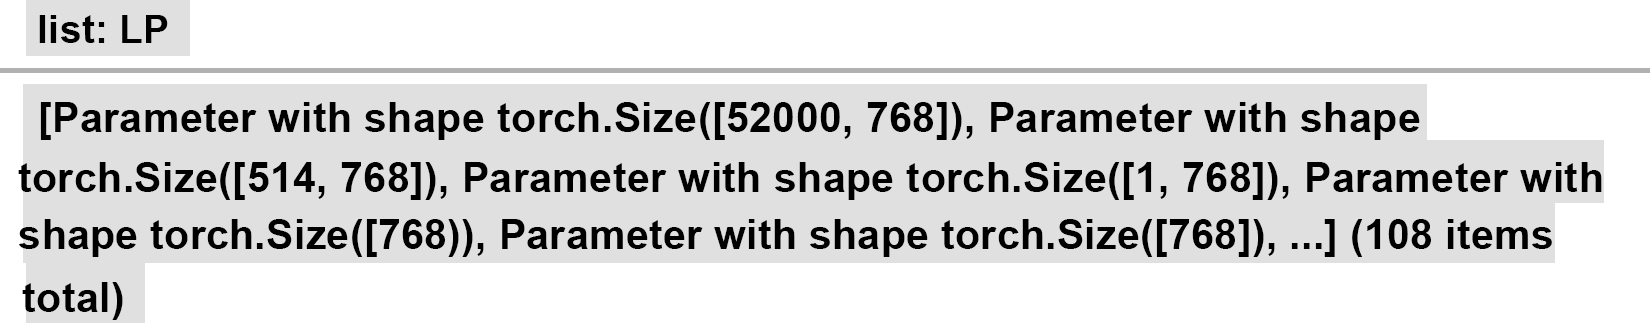

In [5]:
Image('https://github.com/Denis2054/Transformers-for-NLP-2nd-Edition/raw/main/Notebook%20images/04/B17948_04_04.png', width=600) #This is used for rendering images in the notebook

In [ ]:
#@title Counting the parameters
np=0
for p in range(0,lp):#number of tensors
  PL2=True
  try:
    L2=len(LP[p][0]) #check if 2D
  except:
    L2=1             #not 2D but 1D
    PL2=False
  L1=len(LP[p])      
  L3=L1*L2
  np+=L3             # number of parameters per tensor
  if PL2==True:
    print(p,L1,L2,L3)  # displaying the sizes of the parameters
  if PL2==False:
    print(p,L1,L3)  # displaying the sizes of the parameters

print(np)              # total number of parameters

0 52000 768 39936000
1 514 768 394752
2 1 768 768
3 768 768
4 768 768
5 768 768 589824
6 768 768
7 768 768 589824
8 768 768
9 768 768 589824
10 768 768
11 768 768 589824
12 768 768
13 768 768
14 768 768
15 3072 768 2359296
16 3072 3072
17 768 3072 2359296
18 768 768
19 768 768
20 768 768
21 768 768 589824
22 768 768
23 768 768 589824
24 768 768
25 768 768 589824
26 768 768
27 768 768 589824
28 768 768
29 768 768
30 768 768
31 3072 768 2359296
32 3072 3072
33 768 3072 2359296
34 768 768
35 768 768
36 768 768
37 768 768 589824
38 768 768
39 768 768 589824
40 768 768
41 768 768 589824
42 768 768
43 768 768 589824
44 768 768
45 768 768
46 768 768
47 3072 768 2359296
48 3072 3072
49 768 3072 2359296
50 768 768
51 768 768
52 768 768
53 768 768 589824
54 768 768
55 768 768 589824
56 768 768
57 768 768 589824
58 768 768
59 768 768 589824
60 768 768
61 768 768
62 768 768
63 3072 768 2359296
64 3072 3072
65 768 3072 2359296
66 768 768
67 768 768
68 768 768
69 768 768 589824
70 768 768
71 768 768

#Step 10: Building the dataset

In [ ]:
#@title Step 10: Building the Dataset
%%time
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="./kant.txt",
    block_size=128,
)

/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/language_modeling.py:125: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


CPU times: user 26.5 s, sys: 813 ms, total: 27.3 s
Wall time: 27 s


#Step 11: Defining a data collator

In [ ]:
#@title Step 11: Defining a Data Collator
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

#Step 12: Initializing the trainer

In [ ]:
#@title Step 12: Initializing the Trainer
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./KantaiBERT",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=64,
    save_steps=10_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

#Step 13: Pretraining the model

In [ ]:
#@title Step 13: Pre-training the Model
%%time
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 170964
  Num Epochs = 1
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 2672


Step,Training Loss
500,6.602000
1000,5.749000
1500,5.270200
2000,5.015100
2500,4.866900




Training completed. Do not forget to share your model on huggingface.co/models =)




CPU times: user 5min 31s, sys: 1.97 s, total: 5min 33s
Wall time: 5min 31s


TrainOutput(global_step=2672, training_loss=5.456830921287308, metrics={'train_runtime': 331.0369, 'train_samples_per_second': 516.45, 'train_steps_per_second': 8.072, 'total_flos': 873620128952064.0, 'train_loss': 5.456830921287308, 'epoch': 1.0})

#Step 14: Saving the final model (+tokenizer + config) to disk

In [ ]:
#@title Step 14: Saving the Final Model(+tokenizer + config) to disk
trainer.save_model("./KantaiBERT")

Saving model checkpoint to ./KantaiBERT
Configuration saved in ./KantaiBERT/config.json
Model weights saved in ./KantaiBERT/pytorch_model.bin


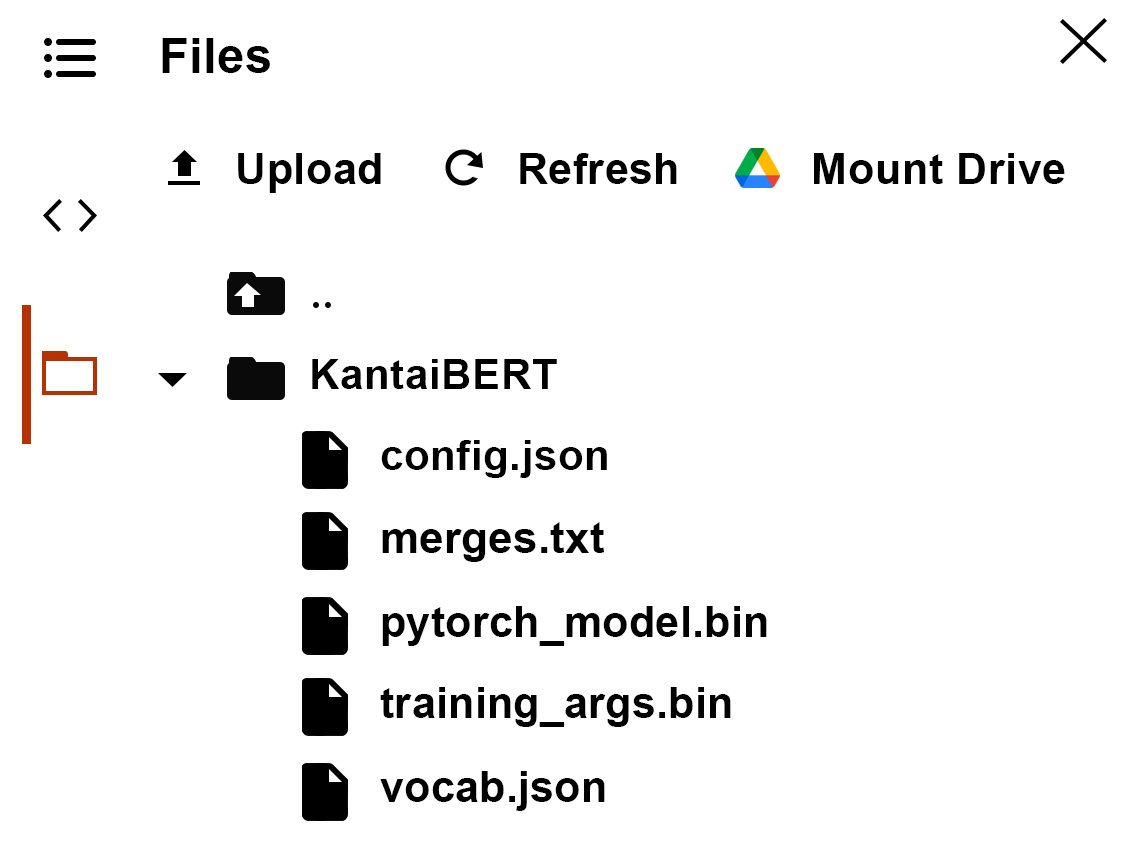

In [7]:
Image('https://github.com/Denis2054/Transformers-for-NLP-2nd-Edition/raw/main/Notebook%20images/04/B17948_04_05.png', width=400) #This is used for rendering images in the notebook

#Step 15: Language modeling with FillMaskPipeline

In [ ]:
#@title Step 15: Language Modeling with the FillMaskPipeline
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model="./KantaiBERT",
    tokenizer="./KantaiBERT"
)

loading configuration file ./KantaiBERT/config.json
Model config RobertaConfig {
  "_name_or_path": "./KantaiBERT",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}

loading configuration file ./KantaiBERT/config.json
Model config RobertaConfig {
  "_name_or_path": "./KantaiBERT",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dro

In [ ]:
fill_mask("Human thinking involves human <mask>.")

[{'score': 0.04037218913435936,
  'sequence': 'Human thinking involves human reason.',
  'token': 393,
  'token_str': ' reason'},
 {'score': 0.016451537609100342,
  'sequence': 'Human thinking involves human experience.',
  'token': 531,
  'token_str': ' experience'},
 {'score': 0.009860575199127197,
  'sequence': 'Human thinking involves human conceptions.',
  'token': 605,
  'token_str': ' conceptions'},
 {'score': 0.009715848602354527,
  'sequence': 'Human thinking involves human law.',
  'token': 446,
  'token_str': ' law'},
 {'score': 0.008748612366616726,
  'sequence': 'Human thinking involves human understanding.',
  'token': 600,
  'token_str': ' understanding'}]